[SHAP 강의들어보기](https://www.youtube.com/watch?v=f2XqxOny3NA)

# ** 06.SHAP Code 실습**

[목적]
  - Global Importance Score와 Local Importance Score 계산
  - SHAP Page 활용 Locality 실습

[Process]
  1. Define X's & Y
  2. Split Train & Valid dataset
  3. Modeling
  4. Model 해석
  5. Black Box 해석

SHAP (SHapley Additive exPlanations)은 머신러닝 모델의 예측을 설명하기 위한 도구입니다. 이는 각 특성이 예측에 얼마나 영향을 미치는지를 계산하기 위해 게임이론의 개념을 활용합니다. SHAP는 모델-독립적이므로 다양한 모델에 적용할 수 있습니다.

다음에 주어진 내용을 상세하게 설명하겠습니다:

- Define X's & Y:

  - 데이터 세트에서 독립 변수 (특성)를 'X'로 정의하고, 종속 변수 (타깃 레이블)를 'Y'로 정의합니다.
- Split Train & Valid dataset:

  - 모델 학습 및 검증을 위해 주어진 데이터를 학습 데이터와 검증 데이터로 분할합니다. 이는 과적합을 피하고 모델의 일반화 성능을 평가하는 데 도움이 됩니다.
- Modeling:

  - X와 Y를 사용하여 머신러닝 모델 (예: 결정 트리, 랜덤 포레스트, XGBoost 등)을 학습합니다.
- Model 해석:

  - 학습된 모델의 결과와 성능을 해석합니다. SHAP를 사용하지 않는 일반적인 모델 해석 방법으로, 특성 중요도, 트리 시각화 등이 포함될 수 있습니다.
- Black Box 해석:

  - SHAP를 사용하여 "블랙 박스"로 간주되는 복잡한 모델의 예측을 설명합니다.
  - SHAP 값은 각 특성이 특정 예측에 미치는 영향의 크기와 방향을 나타냅니다.
  - Global Importance Score: 모든 데이터 포인트에 대한 특성의 평균 SHAP 값입니다. 이를 통해 전체 데이터 세트에서 어떤 특성이 가장 중요한지 파악할 수 있습니다.
  - Local Importance Score: 개별 데이터 포인트의 예측에 각 특성이 얼마나 영향을 미치는지를 나타내는 SHAP 값입니다. 이를 통해 개별 예측의 이유를 파악할 수 있습니다.
  - SHAP Page 활용 Locality 실습: SHAP 라이브러리는 데이터 포인트의 SHAP 값에 대한 시각적 해석을 제공하는 그래픽 도구를 포함하고 있습니다. 이 도구를 사용하여 개별 예측의 로컬 설명을 확인할 수 있습니다.
  
이러한 과정을 통해, SHAP는 머신러닝 모델의 예측을 더 투명하게 만들고, 모델이 주어진 예측을 수행하는 데 있어 각 특성의 영향을 파악하는 데 도움을 줍니다.

In [2]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 4.8 MB/s eta 0:00:00


In [3]:
import os
import gc
import re
import pickle
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import shap

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from lightgbm import LGBMClassifier, LGBMRegressor
from collections import Counter

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [4]:
# Data Loading (수술 時 사망 데이터)
data=pd.read_csv("https://raw.githubusercontent.com/GonieAhn/Data-Science-online-course-from-gonie/main/Data%20Store/example_data.csv")
# Data Checking
col = []
missing = []
level = []
for name in data.columns:

    # Missing
    missper = data[name].isnull().sum() / data.shape[0]
    missing.append(round(missper, 4))

    # Leveling
    lel = data[name].dropna()
    level.append(len(list(set(lel))))

    # Columns
    col.append(name)

summary = pd.concat([pd.DataFrame(col, columns=['name']),
                     pd.DataFrame(missing, columns=['Missing Percentage']),
                     pd.DataFrame(level, columns=['Level'])], axis=1)

drop_col = summary['name'][(summary['Level'] <= 1) | (summary['Missing Percentage'] >= 0.8)]
data.drop(columns=drop_col, inplace=True)
print(">>>> Data Shape : {}".format(data.shape))


>>>> Data Shape : (532, 22)


In [5]:
# X's & Y Split
Y = data['censor']
X = data.drop(columns=['censor'])
idx = list(range(X.shape[0]))
train_idx, valid_idx = train_test_split(idx, test_size=0.3, random_state=2021)
print(">>>> # of Train data : {}".format(len(train_idx)))
print(">>>> # of valid data : {}".format(len(valid_idx)))
print(">>>> # of Train data Y : {}".format(Counter(Y.iloc[train_idx])))
print(">>>> # of valid data Y : {}".format(Counter(Y.iloc[valid_idx])))

>>>> # of Train data : 372
>>>> # of valid data : 160
>>>> # of Train data Y : Counter({0: 241, 1: 131})
>>>> # of valid data Y : Counter({0: 110, 1: 50})


In [6]:
# n_estimators
n_tree = [5, 10, 20]
# learning_rate
l_rate = [0.1, 0.3]
# max_depth
m_depth = [3, 5]
# reg_alpha
L1_norm = [0.1, 0.3, 0.5]

# Modeling
save_n = []
save_l = []
save_m = []
save_L1 = []
f1_score_ = []

cnt = 0

for n in n_tree:
    for l in l_rate:
        for m in m_depth:
            for L1 in L1_norm:

                print(">>> {} <<<".format(cnt))
                cnt +=1
                print("n_estimators : {}, learning_rate : {}, max_depth : {}, reg_alpha : {}".format(n, l, m, L1))
                model = LGBMClassifier(n_estimators=n, learning_rate=l,
                                       max_depth=m, reg_alpha=L1,
                                       n_jobs=-1, objective='cross_entropy')
                model.fit(X.iloc[train_idx], Y.iloc[train_idx])


                # Train Acc
                y_pre_train = model.predict(X.iloc[train_idx])
                cm_train = confusion_matrix(Y.iloc[train_idx], y_pre_train)
                print("Train Confusion Matrix")
                print(cm_train)
                print("Train Acc : {}".format((cm_train[0,0] + cm_train[1,1])/cm_train.sum()))
                print("Train F1-Score : {}".format(f1_score(Y.iloc[train_idx], y_pre_train)))

                # Test Acc
                y_pre_test = model.predict(X.iloc[valid_idx])
                cm_test = confusion_matrix(Y.iloc[valid_idx], y_pre_test)
                print("Test Confusion Matrix")
                print(cm_test)
                print("TesT Acc : {}".format((cm_test[0,0] + cm_test[1,1])/cm_test.sum()))
                print("Test F1-Score : {}".format(f1_score(Y.iloc[valid_idx], y_pre_test)))
                print("-----------------------------------------------------------------------")
                print("-----------------------------------------------------------------------")
                save_n.append(n)
                save_l.append(l)
                save_m.append(m)
                save_L1.append(L1)
                f1_score_.append(f1_score(Y.iloc[valid_idx], y_pre_test))


                #joblib.dump(model, './LightGBM_model/Result_{}_{}_{}_{}_{}.pkl'.format(n, l, m, L1, round(save_acc[-1], 4)))
                #gc.collect()
print(">>> {} <<<\nBest Test f1-score : {}\nBest n_estimators : {}\nBest Learning Rate : {}\nBest Max_depth : {}\nBest L1-norm : {}".format(np.argmax(f1_score_),
                                                                                                                                            f1_score_[np.argmax(f1_score_)],
                                                                                                                                            save_n[np.argmax(f1_score_)],
                                                                                                                                            save_l[np.argmax(f1_score_)],
                                                                                                                                            save_m[np.argmax(f1_score_)],
                                                                                                                                            save_L1[np.argmax(f1_score_)]))
best_model = LGBMClassifier(n_estimators=save_n[np.argmax(f1_score_)], learning_rate=save_l[np.argmax(f1_score_)],
                           max_depth=save_m[np.argmax(f1_score_)], reg_alpha=save_L1[np.argmax(f1_score_)], objective='cross_entropy',
                           random_state=119)
best_model.fit(X.iloc[train_idx], Y.iloc[train_idx])

# Train Acc
y_pre_train = best_model.predict(X.iloc[train_idx])
cm_train = confusion_matrix(Y.iloc[train_idx], y_pre_train)
print("Train Confusion Matrix")
print(cm_train)
print("Train Acc : {}".format((cm_train[0,0] + cm_train[1,1])/cm_train.sum()))
print("Train F1-Score : {}".format(f1_score(Y.iloc[train_idx], y_pre_train)))

# Test Acc
y_pre_test = best_model.predict(X.iloc[valid_idx])
cm_test = confusion_matrix(Y.iloc[valid_idx], y_pre_test)
print("Test Confusion Matrix")
print(cm_test)
print("TesT Acc : {}".format((cm_test[0,0] + cm_test[1,1])/cm_test.sum()))
print("Test F1-Score : {}".format(f1_score(Y.iloc[valid_idx], y_pre_test)))

>>> 0 <<<
n_estimators : 5, learning_rate : 0.1, max_depth : 3, reg_alpha : 0.1
[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 372.000000
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.111990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 372, number of used features: 20
[LightGBM] [Info] [cross_entropy:BoostFromScore]: pavg = 0.352151 -> initscore = -0.609600
[LightGBM] [Info] Start training from score -0.609600
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

    Score  Feature
0      10    event
1       4    cd496
2       4    cd420
3       4     cd40
4       3  preanti
5       2     wtkg
6       2     race
7       1      z30
8       1      age
9       0  symptom
10      0    strat
11      0     str2
12      0        r
13      0   oprior
14      0   karnof
15      0     homo
16      0     hemo
17      0   gender
18      0    drugs
19      0    cd820
20      0     cd80


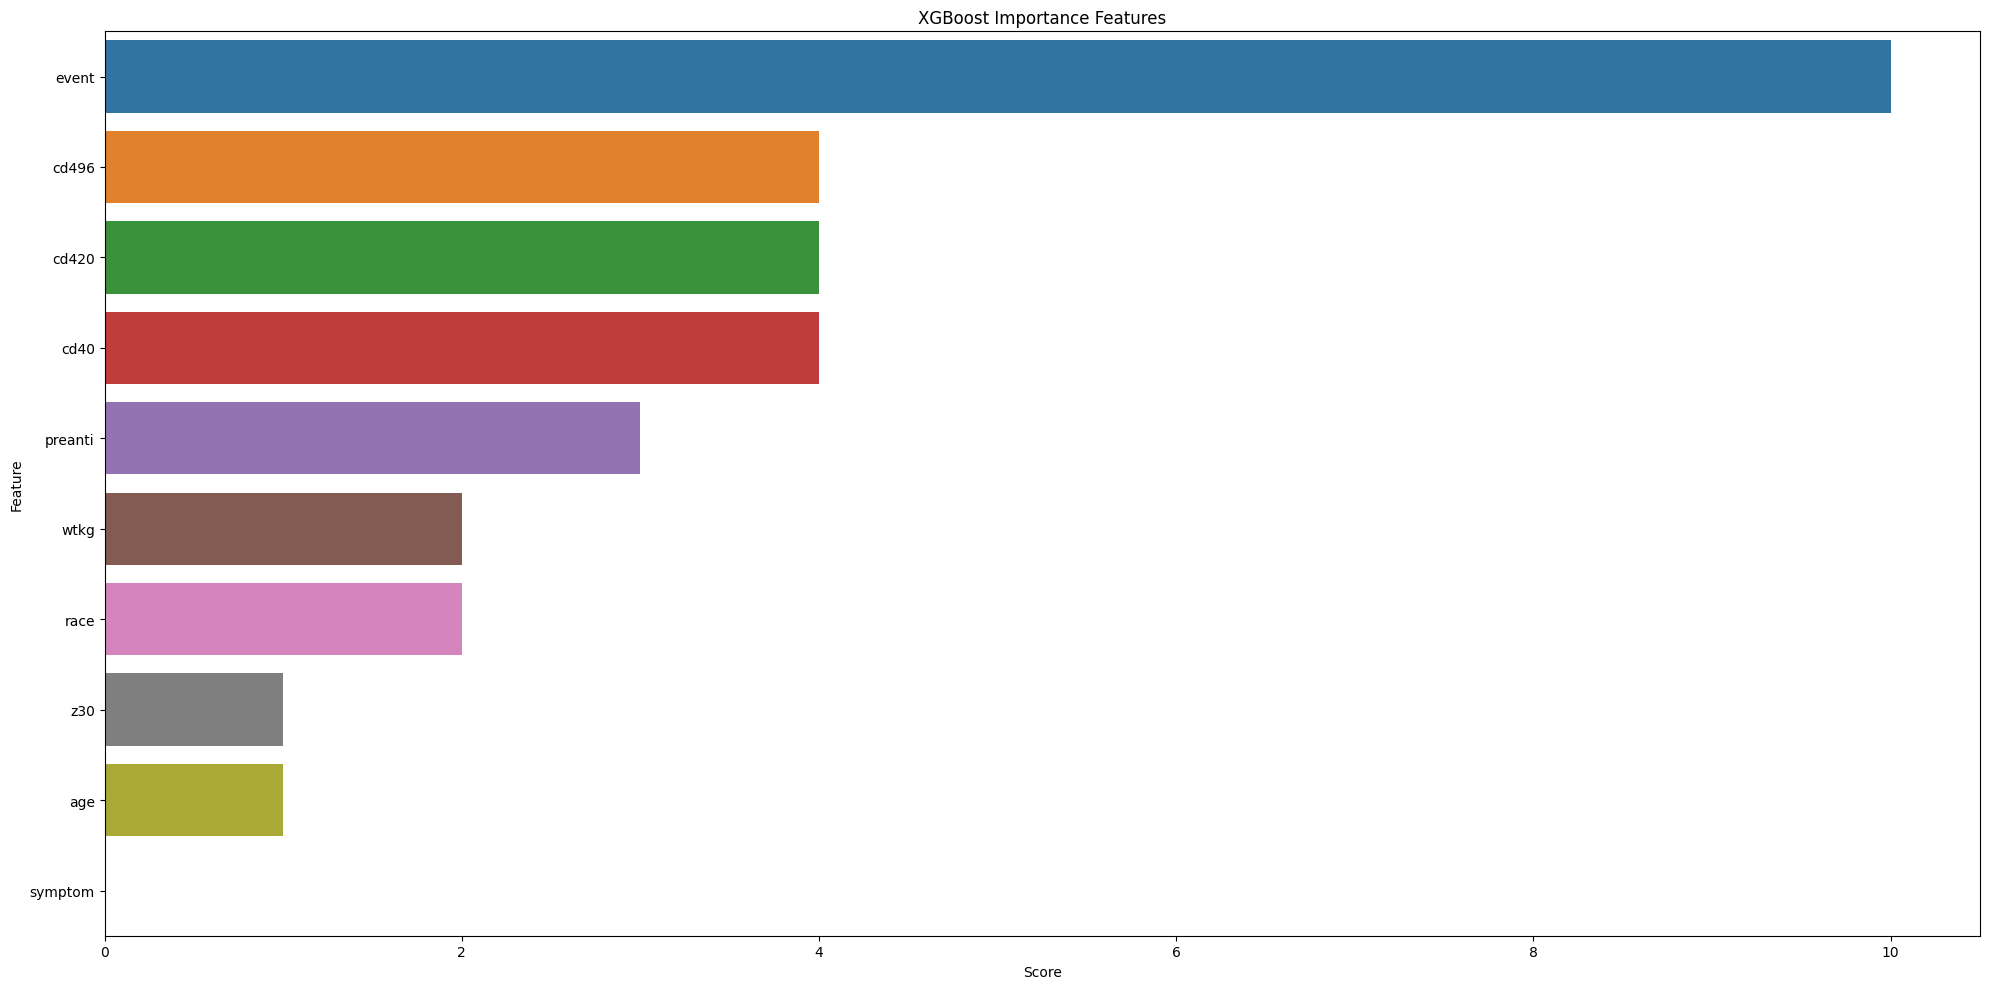

In [7]:
feature_map = pd.DataFrame(sorted(zip(best_model.feature_importances_, X.columns), reverse=True), columns=['Score', 'Feature'])
print(feature_map)
# Importance Score Top 10
feature_map_10 = feature_map.iloc[:10]
plt.figure(figsize=(20, 10))
sns.barplot(x="Score", y="Feature", data=feature_map_10.sort_values(by="Score", ascending=False), errwidth=40)
plt.title('XGBoost Importance Features')
plt.tight_layout()
plt.show()

[SHAPely Values]
  - Package : https://shap.readthedocs.io/en/latest/
  - Package Code & Example : https://github.com/slundberg/shap

[SHAPely Values 내장 함수]
  - force_plot : 특정 데이터 하나 또는 전체 데이터에 대해 Shapley value를 1차원 평면에 정렬하여 보여주는 Plot
  - dependence_plot : 각 특성의 Shapely Value를 확인할 수 있음
    - y축에 나온 특성은 선택한 x와의 관계(상호작용 효과)를 나타냄, 그래프 상에서 색깔이 수직 패턴이 나오는 경우 관계가 존재한다고 판단할 수 잇음
  - Summary_plot : Global하게 Shapely value를 보여주는 plot
    - shapely value 분포에 어떤 영향을 미치는지 시각화 해줌
    - shap_interaction_values : X's 간 관계 (상관관계)를 파악할 수 있는 Plot

[SHAPely Values 주의 사항]
  1. Shapely Values를 계산할 때 시간이 오래걸림
  2. 데이터가 크면 클수록 시간이 많이 걸리기 때문에 원하는 Index만 추출하여 계산하는 것을 추천함
  3. 현재 데이터는 많지 않기 때문에 전체에 대해서 진행할 예정

[TreeExplainer]
  - While SHAP can explain the output of any machine learning model, we have developed a high-speed exact algorithm for tree ensemble methods (see our Nature MI paper). Fast C++ implementations are supported for XGBoost, LightGBM, CatBoost, scikit-learn and pyspark tree models
  
[GradientExplainer]
  - Expected gradients combines ideas from Integrated Gradients, SHAP, and SmoothGrad into a single expected value equation. This allows an entire dataset to be used as the background distribution (as opposed to a single reference value) and allows local smoothing. If we approximate the model with a linear function between each background data sample and the current input to be explained, and we assume the input features are independent then expected gradients will compute approximate SHAP values. In the example below we have explained how the 7th intermediate layer of the VGG16 ImageNet model impacts the output probabilities.

[KernelExplainer] - 시간 엄청 오래 걸림...
  - Kernel SHAP uses a specially-weighted local linear regression to estimate SHAP values for any model. Below is a simple example for explaining a multi-class SVM on the classic iris dataset.



[SHAPEly 가치 주의사항]
   1. Shapely Values를 부담할 때 시간이 오래걸림
   2. 데이터가 크면 클수록 시간이 많이 걸리기 때문에 원하는 인덱스만 추출하여 추출하는 것을 추천함
   3. 현재 데이터는 최대한 노력하는 만큼만을 추구합니다

[트리설명자]
   - SHAP는 모든 기계 학습 모델의 출력을 설명할 수 있지만 트리 앙상블 방법을 위한 고속 정확한 알고리즘을 개발했습니다(Nature MI 논문 참조). XGBoost, LightGBM, CatBoost, scikit-learn 및 pyspark 트리 모델에 대해 빠른 C++ 구현이 지원됩니다.
  
[그라디언트 설명자]
   - 예상 그라디언트는 통합 그라디언트, SHAP 및 SmoothGrad의 아이디어를 단일 기대값 방정식으로 결합합니다. 이를 통해 전체 데이터 세트를 배경 분포(단일 참조 값이 아닌)로 사용할 수 있으며 로컬 평활화가 가능합니다. 각 배경 데이터 샘플과 설명할 현재 입력 사이의 선형 함수를 사용하여 모델을 근사화하고 입력 특성이 독립적이라고 가정하면 예상 기울기가 대략적인 SHAP 값을 계산합니다. 아래 예에서는 VGG16 ImageNet 모델의 7번째 중간 계층이 출력 확률에 어떻게 영향을 미치는지 설명했습니다.

[KernelExplainer] - 엄청나게 오래된 걸림...
   - 커널 SHAP는 특별히 가중치가 부여된 로컬 선형 회귀를 사용하여 모든 모델의 SHAP 값을 추정합니다. 아래는 클래식 붓꽃 데이터세트의 다중 클래스 SVM을 설명하는 간단한 예입니다.

In [8]:
# SHAP Explainer 만들기
explainer = shap.TreeExplainer(best_model)
# Shap values 계산
shap_values = explainer.shap_values(X.iloc[train_idx])

In [9]:
X.iloc[train_idx].shape

(372, 21)

In [10]:
shap_values.shape

(372, 21)

In [12]:
#force_plot : 특정 데이터 하나 또는 전체 데이터에 대해 Shapley value를 1차원 평면에 정렬하여 보여주는 Plot
# 예시는 첫번째 데이터에 대해
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[2, :], X.iloc[train_idx[2], :], link="logit")

In [13]:
Y.iloc[train_idx[2]]

1

In [14]:
# 누적 시각화
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X.iloc[train_idx])

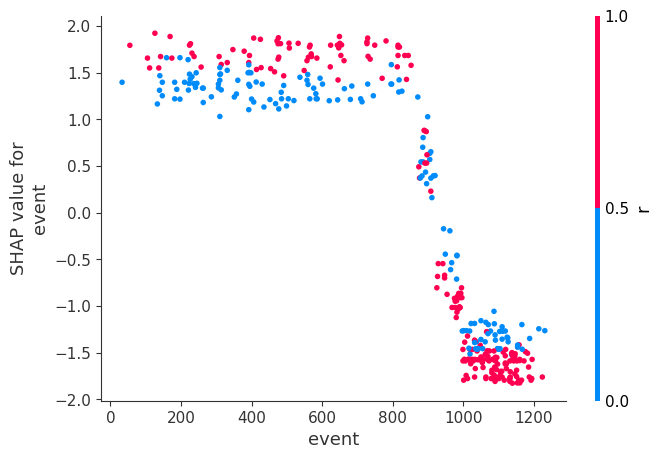

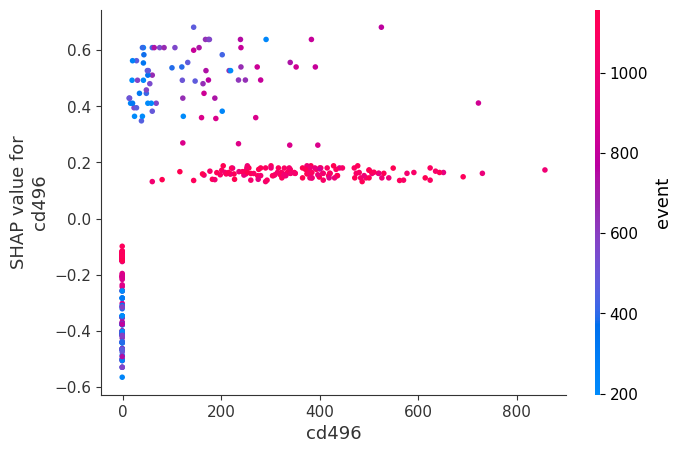

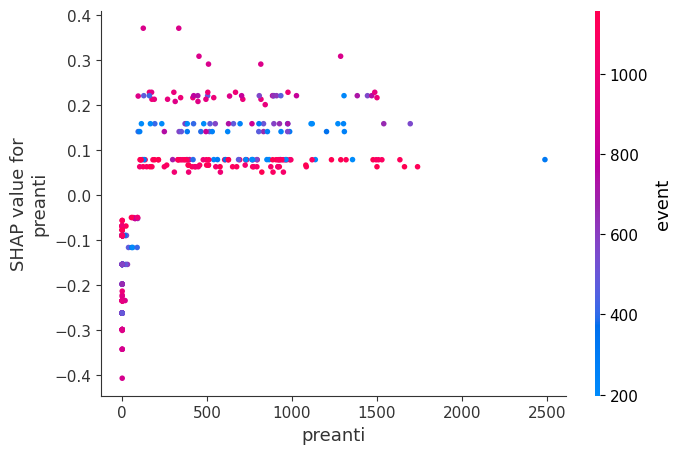

In [15]:
# Shap Value의 절대 값이 큰 순서대로 정렬함
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))
# 영향력 Top 3에 대한 Dependence plot
for i in range(3):
    shap.dependence_plot(top_inds[i], shap_values, X.iloc[train_idx])

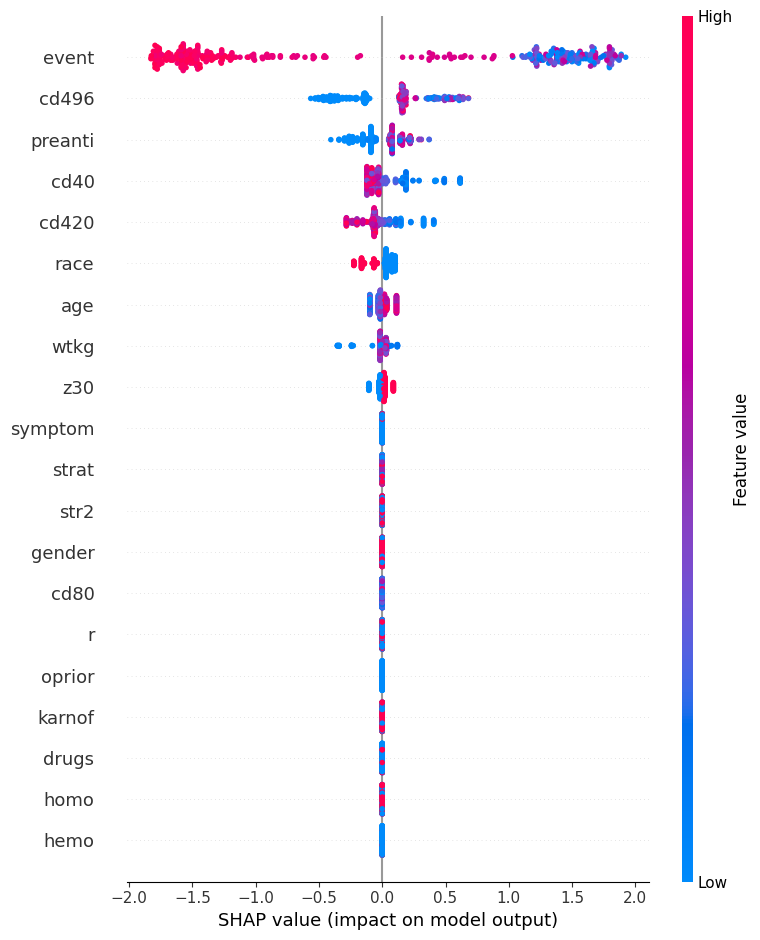

In [16]:
# Global Importance Score
shap.summary_plot(shap_values, X.iloc[train_idx])

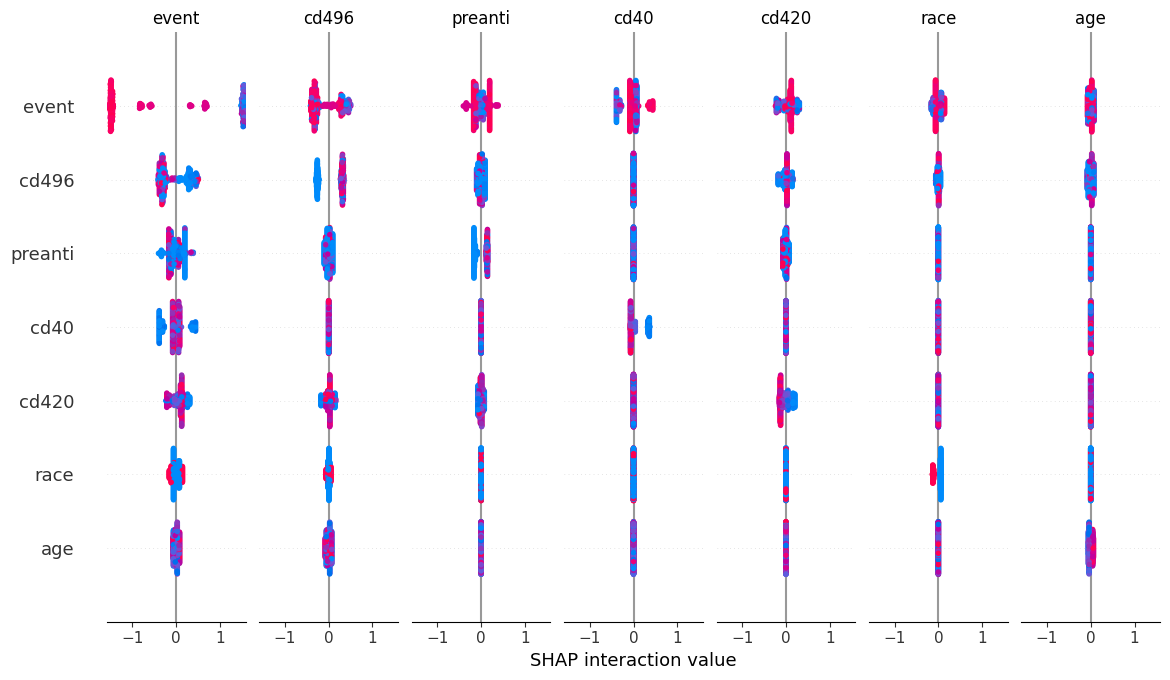

In [17]:
# Interaction Plot
shap_interaction_values = explainer.shap_interaction_values(X.iloc[train_idx])
shap.summary_plot(shap_interaction_values, X.iloc[train_idx])